In [18]:
import torch
from torch.utils.data import DataLoader

from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import evaluate, get_grapher, evaluate_r2, load_model
from bondnet.data.dataset import ReactionNetworkDatasetGraphs, train_validation_test_split
from bondnet.data.dataloader import DataLoaderReactionNetwork

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
settings_file = "./best_models/settings3.txt"
dict_train = parse_settings(settings_file)
dict_train["gpu"] = device


using the following settings:
----------------------------------------
dataset loc:                     ../../../dataset/qm_9_hydro_merged_3.json
Small Dataset?:                  False
augment:                         False
restore:                         False
freeze graph layers w/transfer:  False
distributed:                     False
on gpu:                          True
filter species?                  [3, 6]
filter outliers?                 True
filter sparse rxns?              False
num gpu:                         1
featurizer filter:               False
extra features:                  ['bond_length']
hyperparam save file:            ./hyper.pkl
dataset state dict:              ./dataset_state_dict.pkl
model dir                        ./
classifier                       False
category weights:                [1.0, 1.5, 2.0]
batch size:                      256
epochs:                          500
lr:                              0.001000
weight decay:                    0.000

In [3]:
# this dataset is a random subset of qm_9_qtaim_3

dataset = ReactionNetworkDatasetGraphs(
        grapher=get_grapher(dict_train["extra_features"]), 
        file="../dataset/qm_9_hydro_100.json", 
        out_file="./", 
        target = 'dG_sp', 
        classifier = dict_train["classifier"], 
        classif_categories=None, 
        filter_species = dict_train["filter_species"],
        filter_sparse_rxns=dict_train["filter_sparse_rxns"],
        filter_outliers=dict_train["filter_outliers"],
        debug = dict_train["debug"],
        device = dict_train["gpu"],
        extra_keys = dict_train["extra_features"]
    )
    

reading file from: ../dataset/qm_9_hydro_100.json
Function raised unhashable type: 'list'
Traceback (most recent call last):
  File "/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pebble/common.py", line 174, in process_execute
    return function(*args, **kwargs)
  File "/home/santiagovargas/dev/bondnet/bondnet/dataset/mg_barrier.py", line 472, in process_species_graph
    extra_feats_bond=extra_bond_feats_dict_prod,
  File "/home/santiagovargas/dev/bondnet/bondnet/dataset/mg_barrier.py", line 147, in split_and_map
    G.add_edge(i[0], i[1])
  File "/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/networkx/classes/graph.py", line 879, in add_edge
    if u not in self._node:
TypeError: unhashable type: 'list'

Function raised unhashable type: 'list'
Traceback (most recent call last):
  File "/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/pebble/common.py", line 174, in process_execute
    return function(*args, **

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 178
labels: 84
molecules: 178
constructing graphs & features....
number of graphs valid: 178
number of graphs: 178


In [30]:
# load model - this is the "recommended" way but it's a lil more annoying

# initantiating model 
dict_train['in_feats'] = dataset.feature_size
model = load_model(dict_train)[0]
#load model
model.load_state_dict(torch.load("./best_models/best3.pkl"))

<All keys matched successfully>

In [34]:
# alternative way to load model 
model = torch.load("./best_models/best3.pt")

In [35]:
trainset, valset, testset = train_validation_test_split(
        dataset, validation=0.15, test=0.15)
    
test_dataset_loader = DataLoaderReactionNetwork(dataset, batch_size=len(dataset), shuffle=False)

model.cuda() # laod to gpu

GatedGCNReactionNetwork(
  (embedding): UnifySize(
    (linears): ModuleDict(
      (atom): Linear(in_features=13, out_features=20, bias=False)
      (bond): Linear(in_features=8, out_features=20, bias=False)
      (global): Linear(in_features=7, out_features=20, bias=False)
    )
  )
  (gated_layers): ModuleList(
    (0): GatedGCNConv(
      (activation): ReLU()
      (A): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=20, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): Identity()
        )
      )
      (B): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=20, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): Identity()
        )
      )
      (C): LinearN(
        (fc_layers): ModuleList(
          (0): Linear(in_features=20, out_features=512, bias=True)
      

(2.868594759986514, 0.24838542938232422)

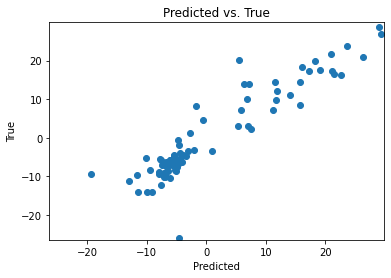

In [36]:
feature_names = ["atom", "bond", "global"]
import numpy as np
import matplotlib.pyplot as plt
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss

def evaluate(model, nodes, data_loader, device=None, plot = False, name = "true_pred"):
    """
    basic loop for training a regressor. Gets mae
        
    Args:
        model(pytorch model): pytorch model
        nodes(dict): node feature dictionary
        data_loader(loader obj): loader object with data to eval
        device(str): cpu/gpu
    Returns: 
        mae(float): mae
    """
    metric_fn = WeightedL1Loss(reduction="sum")

    model.eval()

    with torch.no_grad():
        count, mae, mae_no_std = 0.0, 0.0, 0.0

        for it, (batched_graph, label) in enumerate(data_loader):
            feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
            target = label["value"].view(-1)
            norm_atom = label["norm_atom"]
            #norm_atom = None
            norm_bond = label["norm_bond"]
            #norm_bond = None
            stdev = label["scaler_stdev"]

            if device is not None:
                feats = {k: v.to(device) for k, v in feats.items()}
                target = target.to(device)
                norm_atom = norm_atom.to(device)
                norm_bond = norm_bond.to(device)
                stdev = stdev.to(device)
                
            pred = model(
                batched_graph, 
                feats, 
                label["reaction"], 
                device=device, 
                norm_atom = norm_atom, 
                norm_bond = norm_bond)
            pred = pred.view(-1)
        
            if plot:
                if device is None: 
                    pred_np = pred.detach().numpy()
                    target_np = target.detach().numpy()
                    stdev_np = stdev.detach().numpy()
                else: 
                    pred_np = pred.detach().cpu().numpy()
                    target_np = target.detach().cpu().numpy()  
                    stdev_np = stdev.detach().cpu().numpy()

                plt.scatter(pred_np * stdev_np, target_np * stdev_np)
                #plt.scatter(pred_np, target_np)
                
                min_val = np.min([np.min(pred_np* stdev_np), np.min(target_np* stdev_np)]) - 0.5
                max_val = np.max([np.max(pred_np* stdev_np), np.max(target_np* stdev_np)]) + 0.5
                plt.ylim(min_val,max_val)
                plt.xlim(min_val,max_val)
                plt.title("Predicted vs. True")
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.savefig("./{}.png".format(name))

            mae += metric_fn(pred, target, stdev).detach().item() 
            mae_no_std += metric_fn(pred, target, None).detach().item()
            count += len(target)

    l1_acc = mae / count
    l1_acc_no_std = mae_no_std / count
    return l1_acc, l1_acc_no_std

            

evaluate(
    model, 
    feature_names, 
    test_dataset_loader, 
    device = dict_train["gpu"], 
    plot=True,
    name = "test_best"
)

In [16]:
train_r2 = evaluate_r2(
    model, 
    feature_names, 
    test_dataset_loader, 
    device = dict_train["gpu"]
    )

In [17]:
train_r2

tensor(0.8588, device='cuda:0')